# Task 1: Descriptive Analytics
You have been asked to present to EZ leadership on demand patterns at EZ nationwide. Analyze the data available from this perspective. Create a slide deck for the presentation with data and visuals (no more than title slide + 3 slides). Share both the slide deck and code / files used to create the deck.

## 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import (
    r2_score,
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    log_loss
)

%matplotlib inline

## 2. Load data

In [2]:
journeys = pd.read_csv('../data/journeys.csv')
utilization = pd.read_csv('../data/utilization.csv', sep=';', header=1)

## 3. Data Cleansing

In [5]:
for col in [col for col in journeys.columns if 'Time' in col]:
    journeys[col] = pd.to_datetime(journeys[col])

In [6]:
journeys.columns = [col.lower().replace(' ', '_') for col in journeys.columns]

In [7]:
journeys['trip_sum_trip_price'] = (
    journeys['trip_sum_trip_price'].str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [8]:
journeys['duration'] = (
    journeys['trip_end_at_local_time'] - journeys['trip_start_at_local_time']
)

journeys['duration'] = journeys['duration'].astype('timedelta64[s]')

In [9]:
journeys['creation_to_start'] = (
    journeys['trip_start_at_local_time'] - journeys['trip_created_at_local_time']
)
journeys['creation_to_start'] = journeys['creation_to_start'].astype('timedelta64[s]')

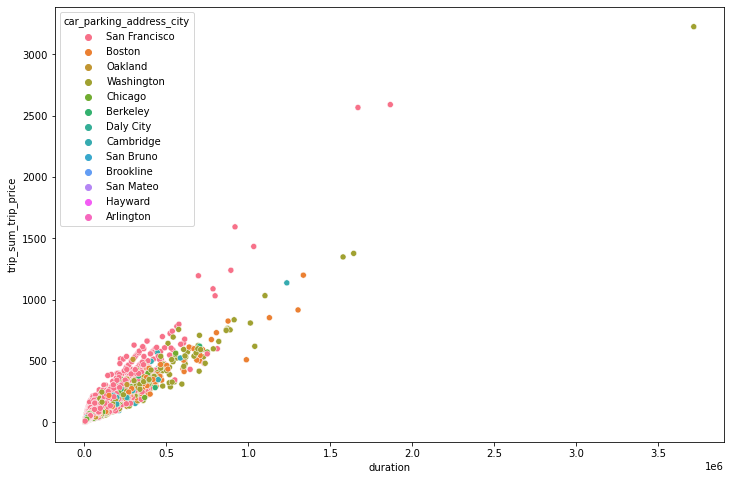

In [14]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x='duration',
    y='trip_sum_trip_price',
    hue='car_parking_address_city',
    data=journeys
);

In [15]:
journeys['start_hour'] = journeys['trip_start_at_local_time'].dt.hour
journeys['finish_hour'] = journeys['trip_end_at_local_time'].dt.hour

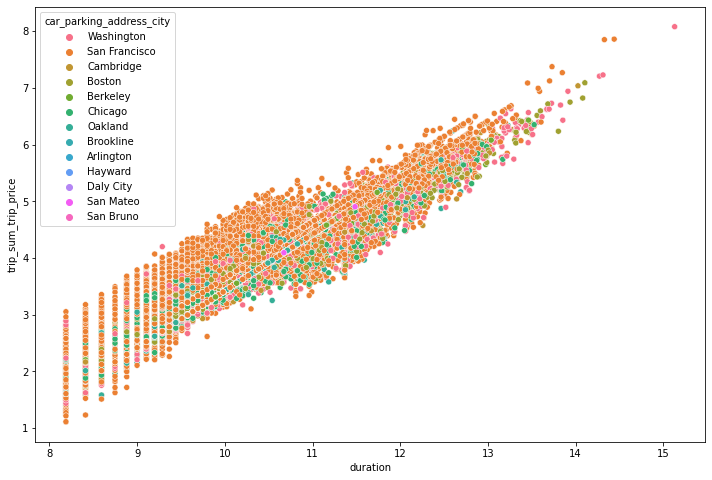

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=np.log(journeys['duration']),
    y=np.log(journeys['trip_sum_trip_price']),
    hue='car_parking_address_city',
    data=journeys
);

## Baseline model to understand the problem

In [16]:
formula = (
    "np.log(trip_sum_trip_price)"
    + " ~ np.log(duration)"
    + " + C(start_hour) + C(finish_hour) + C(car_parking_address_city)"
    + " + np.log(creation_to_start)"
)
model = smf.ols(formula, data=journeys)
fitted = model.fit()
fitted.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
==============================================================================================
Model:                     OLS                              Adj. R-squared:          0.900    
Dependent Variable:        np.log(trip_sum_trip_price)      AIC:                     3320.5011
Date:                      2022-06-14 02:01                 BIC:                     3866.0028
No. Observations:          56537                            Log-Likelihood:          -1599.3  
Df Model:                  60                               F-statistic:             8484.    
Df Residuals:              56476                            Prob (F-statistic):      0.00     
R-squared:                 0.900                            Scale:                   0.062025 
----------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------------------
Intercept                                    -4.2480   0.0328 -129.6814 0.0000 -4.3122 -4.1838
C(start_hour)[T.1]                           -0.0000   0.0219   -0.0023 0.9982 -0.0429  0.0428
C(start_hour)[T.2]                            0.0455   0.0215    2.1172 0.0342  0.0034  0.0876
C(start_hour)[T.3]                            0.0845   0.0216    3.9150 0.0001  0.0422  0.1268
C(start_hour)[T.4]                            0.1260   0.0174    7.2254 0.0000  0.0918  0.1602
C(start_hour)[T.5]                            0.1388   0.0157    8.8565 0.0000  0.1081  0.1695
C(start_hour)[T.6]                            0.1232   0.0148    8.3153 0.0000  0.0941  0.1522
C(start_hour)[T.7]                            0.1830   0.0144   12.6959 0.0000  0.1547  0.2112
C(start_hour)[T.8]                            0.2417   0.0143   16.8882 0.0000  0.2137  0.2698
C(start_hour)[T.9]                            0.2680   0.0142   18.8467 0.0000  0.2401  0.2958
C(start_hour)[T.10]                           0.2579   0.0141   18.2360 0.0000  0.2302  0.2856
C(start_hour)[T.11]                           0.2536   0.0142   17.9006 0.0000  0.2258  0.2814
C(start_hour)[T.12]                           0.2383   0.0142   16.7632 0.0000  0.2104  0.2661
C(start_hour)[T.13]                           0.2239   0.0142   15.7216 0.0000  0.1959  0.2518
C(start_hour)[T.14]                           0.1851   0.0143   12.9531 0.0000  0.1571  0.2131
C(start_hour)[T.15]                           0.1417   0.0143    9.9350 0.0000  0.1137  0.1696
C(start_hour)[T.16]                           0.1194   0.0142    8.4065 0.0000  0.0916  0.1472
C(start_hour)[T.17]                           0.1197   0.0142    8.4100 0.0000  0.0918  0.1475
C(start_hour)[T.18]                           0.1049   0.0143    7.3547 0.0000  0.0769  0.1328
C(start_hour)[T.19]                           0.0810   0.0144    5.6286 0.0000  0.0528  0.1092
C(start_hour)[T.20]                           0.0569   0.0146    3.9019 0.0001  0.0283  0.0854
C(start_hour)[T.21]                           0.0534   0.0151    3.5259 0.0004  0.0237  0.0831
C(start_hour)[T.22]                           0.0446   0.0158    2.8174 0.0048  0.0136  0.0756
C(start_hour)[T.23]                           0.0090   0.0168    0.5385 0.5902 -0.0239  0.0419
C(finish_hour)[T.1]                           0.0182   0.0080    2.2731 0.0230  0.0025  0.0338
C(finish_hour)[T.2]                           0.0046   0.0086    0.5364 0.5917 -0.0122  0.0214
C(finish_hour)[T.3]                           0.0056   0.0091    0.6186 0.5362 -0.0122  0.0234
C(finish_hour)[T.4]                          -0.0015   0.0114   -0.1271 0.8989 -0.0239  0.0210
C(finish_hour)[T.5]                           0.0077   0.0126    0.6146 0.5388 -0.0169  0.0324
C(finish_hour)[T.6]                          -0.0383   0.0127   -3.0090 0.0026 -0.0633 -

In [17]:
journeys = journeys.sort_values('trip_created_at_local_time')

In [18]:
journeys['month'] = journeys['trip_created_at_local_time'].dt.month
journeys['day_of_month'] = journeys['trip_created_at_local_time'].dt.day

In [19]:
y = journeys['trip_sum_trip_price']
X = journeys.drop(
    columns=[
        'trip_sum_trip_price',
        'trip_id_hash',
        'car_id_hash',
        'car_parking_address_city',
        'trip_start_at_local_time',
        'trip_end_at_local_time',
        'trip_created_at_local_time']
)

In [41]:
X['log_duration'] = np.log(X['duration'])
X['log_creation_to_start'] = np.log(X['creation_to_start'])
y = np.log(y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [33]:
cat = CatBoostRegressor(cat_features=['finish_hour', 'start_hour', 'car_parking_address_postcode', 'month', 'day_of_month'])

In [65]:
cat.fit(X_train, y_train)

Learning rate set to 0.076046
0:	learn: 0.7378316	total: 27.1ms	remaining: 27.1s
1:	learn: 0.6924608	total: 44.5ms	remaining: 22.2s
2:	learn: 0.6500053	total: 61.1ms	remaining: 20.3s
3:	learn: 0.6112535	total: 74.4ms	remaining: 18.5s
4:	learn: 0.5751743	total: 86.8ms	remaining: 17.3s
5:	learn: 0.5427726	total: 102ms	remaining: 16.9s
6:	learn: 0.5124228	total: 120ms	remaining: 17s
7:	learn: 0.4842919	total: 136ms	remaining: 16.8s
8:	learn: 0.4588798	total: 152ms	remaining: 16.7s
9:	learn: 0.4353476	total: 174ms	remaining: 17.2s
10:	learn: 0.4144112	total: 190ms	remaining: 17.1s
11:	learn: 0.3951040	total: 204ms	remaining: 16.8s
12:	learn: 0.3778462	total: 219ms	remaining: 16.6s
13:	learn: 0.3617410	total: 232ms	remaining: 16.3s
14:	learn: 0.3476929	total: 249ms	remaining: 16.4s
15:	learn: 0.3347367	total: 265ms	remaining: 16.3s
16:	learn: 0.3231565	total: 280ms	remaining: 16.2s
17:	learn: 0.3129109	total: 294ms	remaining: 16s
18:	learn: 0.3037063	total: 309ms	remaining: 15.9s
19:	learn:

In [66]:
y_hat = cat.predict(X_test)

In [67]:
r2_score(y_test, y_hat)

0.9429715918460405

In [68]:
train = pd.concat([X_train, y_train], axis=1)

In [69]:
list(train)

['car_parking_address_postcode',
 'duration',
 'creation_to_start',
 'start_hour',
 'finish_hour',
 'month',
 'day_of_month',
 'log_duration',
 'log_creation_to_start',
 'trip_sum_trip_price']

In [70]:
formula = (
    "trip_sum_trip_price"
    + " ~ log_duration"
    + " + C(start_hour) + C(finish_hour) + C(car_parking_address_postcode)"
    + " + C(day_of_month) + C(month)"
    + " + log_creation_to_start"
)
model = smf.ols(formula, data=train)
fitted = model.fit()
fitted.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
==========================================================================================
Model:                      OLS                       Adj. R-squared:           0.918     
Dependent Variable:         trip_sum_trip_price       AIC:                      -5874.2914
Date:                       2022-06-08 23:50          BIC:                      -4463.5344
No. Observations:           42402                     Log-Likelihood:           3100.1    
Df Model:                   162                       F-statistic:              2942.     
Df Residuals:               42239                     Prob (F-statistic):       0.00      
R-squared:                  0.919                     Scale:                    0.050780  
------------------------------------------------------------------------------------------
                                          Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                -4.3084   0.0281 -153.0565 0.0000 -4.3636 -4.2532
C(start_hour)[T.1]                        0.0258   0.0232    1.1152 0.2648 -0.0196  0.0713
C(start_hour)[T.2]                        0.0827   0.0229    3.6094 0.0003  0.0378  0.1276
C(start_hour)[T.3]                        0.1268   0.0225    5.6323 0.0000  0.0827  0.1709
C(start_hour)[T.4]                        0.1706   0.0183    9.3302 0.0000  0.1348  0.2064
C(start_hour)[T.5]                        0.1614   0.0165    9.7718 0.0000  0.1291  0.1938
C(start_hour)[T.6]                        0.1276   0.0156    8.1936 0.0000  0.0970  0.1581
C(start_hour)[T.7]                        0.1824   0.0152   12.0371 0.0000  0.1527  0.2121
C(start_hour)[T.8]                        0.2232   0.0150   14.8324 0.0000  0.1937  0.2526
C(start_hour)[T.9]                        0.2413   0.0149   16.1429 0.0000  0.2120  0.2706
C(start_hour)[T.10]                       0.2370   0.0149   15.9477 0.0000  0.2079  0.2661
C(start_hour)[T.11]                       0.2359   0.0149   15.8385 0.0000  0.2067  0.2651
C(start_hour)[T.12]                       0.2180   0.0149   14.5890 0.0000  0.1887  0.2473
C(start_hour)[T.13]                       0.2055   0.0150   13.7342 0.0000  0.1762  0.2349
C(start_hour)[T.14]                       0.1759   0.0150   11.7137 0.0000  0.1464  0.2053
C(start_hour)[T.15]                       0.1364   0.0150    9.1031 0.0000  0.1070  0.1657
C(start_hour)[T.16]                       0.1145   0.0149    7.6701 0.0000  0.0853  0.1438
C(start_hour)[T.17]                       0.1132   0.0149    7.5699 0.0000  0.0839  0.1425
C(start_hour)[T.18]                       0.1005   0.0150    6.7066 0.0000  0.0711  0.1299
C(start_hour)[T.19]                       0.0716   0.0151    4.7358 0.0000  0.0419  0.1012
C(start_hour)[T.20]                       0.0510   0.0153    3.3362 0.0009  0.0210  0.0810
C(start_hour)[T.21]                       0.0365   0.0159    2.2932 0.0218  0.0053  0.0677
C(start_hour)[T.22]                       0.0400   0.0165    2.4158 0.0157  0.0075  0.0724
C(start_hour)[T.23]                       0.0073   0.0176    0.4148 0.6783 -0.0272  0.0419
C(finish_hour)[T.1]                       0.0210   0.0083    2.5290 0.0114  0.0047  0.0373
C(finish_hour)[T.2]                       0.0137   0.0089    1.5391 0.1238 -0.0038  0.0312
C(finish_hour)[T.3]                       0.0233   0.0095    2.4637 0.0138  0.0048  0.0419
C(finish_hour)[T.4]                       0.0250   0.0120    2.0878 0.0368  0.0015  0.0484
C(finish_hour)[T.5]                       0.0300   0.0133    2.2610 0.0238  0.0040  0.0560
C(finish_hour)[T.6]                      -0.0426   0.0134   -3.1808 0.0015 -0.0689 -0.0164
C(finish_hour)[T.7]                      -0.0699   0.0132   -5.3042 0.0000 -0.0957 -0.0440
C(finish_hour)[T.8]                      -0.1793   0.0118  -15.2176 

In [79]:
train2 = pd.get_dummies(train, columns=['finish_hour', 'start_hour', 'car_parking_address_postcode', 'month', 'day_of_month'], drop_first=True)

In [94]:
train['trip_sum_trip_price']

41715    3.026746
34377    3.847591
16406    3.688879
29359    3.113515
53980    4.029806
           ...   
48372    2.756840
55571    1.838961
17433    3.504055
20866    2.277267
5740     3.056357
Name: trip_sum_trip_price, Length: 42402, dtype: float64

In [89]:
model = sm.OLS(y_train, sm.add_constant(train2.drop(columns=['trip_sum_trip_price'])))

In [90]:
fitted = model.fit()

In [ ]:
sns.scatterplot(x='dura')

In [91]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     trip_sum_trip_price   R-squared:                       0.920
Model:                             OLS   Adj. R-squared:                  0.919
Method:                  Least Squares   F-statistic:                     2946.
Date:                 Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                         16:23:54   Log-Likelihood:                 3365.2
No. Observations:                42402   AIC:                            -6400.
Df Residuals:                    42237   BIC:                            -4972.
Df Model:                          164                                         
Covariance Type:             nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -4.6021      0.031   -149.713      0.000      -4.662      -4.542
duration                           -6.174e-07   2.75e-08    -22.428      0.000   -6.71e-07   -5.63e-07
creation_to_start                  -2.298e-08    8.3e-09     -2.770      0.006   -3.92e-08   -6.72e-09
log_duration                           0.8368      0.002    419.903      0.000       0.833       0.841
log_creation_to_start                 -0.0074      0.001    -12.023      0.000      -0.009      -0.006
finish_hour_1                          0.0175      0.008      2.121      0.034       0.001       0.034
finish_hour_2                          0.0105      0.009      1.190      0.234      -0.007       0.028
finish_hour_3                          0.0178      0.009      1.888      0.059      -0.001       0.036
finish_hour_4                          0.0192      0.012      1.612      0.107      -0.004       0.042
finish_hour_5                          0.0234      0.013      1.770      0.077      -0.003       0.049
finish_hour_6                         -0.0405      0.013     -3.039      0.002      -0.067      -0.014
finish_hour_7                         -0.0600      0.013     -4.580      0.000      -0.086      -0.034
finish_hour_8                         -0.1606      0.012    -13.682      0.000      -0.184      -0.138
finish_hour_9                         -0.1370      0.010    -14.390      0.000      -0.156      -0.118
finish_hour_10                        -0.1273      0.009    -14.190      0.000      -0.145      -0.110
finish_hour_11                        -0.1165      0.009    -13.321      0.000      -0.134      -0.099
finish_hour_12                        -0.0883      0.008    -10.824      0.000      -0.104      -0.072
finish_hour_13                        -0.0535      0.008     -6.819      0.000      -0.069      -0.038
finish_hour_14                        -0.0369      0.007     -4.928      0.000      -0.052      -0.022
finish_hour_15                        -0.0198      0.007     -2.734      0.006      -0.034      -0.006
finish_hour_16                        -0.0046      0.007     -0.660      0.509      -0.018       0.009
finish_hour_17                         0.0322      0.007      4.716      0.000       0.019       0.046
finish_hour_18                         0.0415      0.007      6.186      0.000       0.028       0.055
finish_hour_19                         0.0356      0.007      5.351      0.000       0.023       0.049
finish_hour_20                         0.0201      0.007      3.064      0.002       0.007       0.033
finish_hour_21                         0.0207      0.007      3.170      0.002       0.008       0.034
finish_hour_22                         0.0200      0.006      3.100      0.002       

In [83]:
test = pd.concat([X_test, y_test], axis=1)

In [84]:
test2 = pd.get_dummies(test, columns=['finish_hour', 'start_hour', 'car_parking_address_postcode', 'month', 'day_of_month'], drop_first=True)

In [92]:
y_hat2 = fitted.predict(sm.add_constant(test2.drop(columns=['trip_sum_trip_price'])))

In [96]:
r2_score(np.exp(y_test), np.exp(y_hat2))

0.8357840640001433

In [93]:
r2_score(y_test, y_hat2)

0.917401495665535

In [98]:
r2_score(np.exp(y_test), np.exp(y_hat))

0.9202801525778919

In [99]:
r2_score(y_test, y_hat)

0.9429715918460405

<AxesSubplot:>

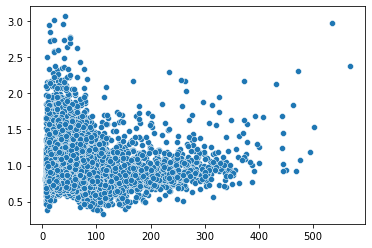

In [107]:
sns.scatterplot(y=np.exp(y_test - y_hat2), x=np.exp(y_hat2))

<AxesSubplot:ylabel='trip_sum_trip_price'>

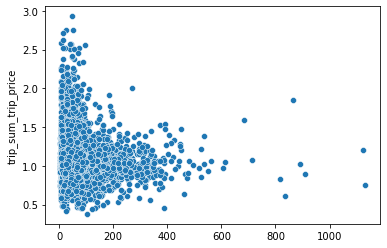

In [108]:
sns.scatterplot(y=np.exp(y_test - y_hat), x=np.exp(y_hat))

In [109]:
mean_absolute_percentage_error(y_test, y_hat)

0.037497885992095

In [110]:
mean_absolute_percentage_error(y_test, y_hat2)

0.04891801997498212

In [111]:
mean_absolute_percentage_error(np.exp(y_test),np.exp(y_hat))

0.13060840148265498

In [112]:
mean_absolute_percentage_error(np.exp(y_test),np.exp(y_hat2))

0.17284579006656256